In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/pierreo/bo-on-graph


# Ablation study:
- Influence of Q0
- Influence of order
- Examples of signal with different orders
- Influence of nnode max
- Test on centrality and real world degree

In [3]:
import os
import torch
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
matplotlib.rcParams.update({'font.size': 15})
supported_labels = [
    "random",
    "local_search",
    "ei",
    "ei_ego_network_1",
    "ei_ego_network_1_old",
    "dfs",
    "bfs",
    "ei_ego_network_2",
    "ei_ego_network_2_no_ard",
]
# cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']))
d_color = {"ei_ego_network_1":"#1f77b4", "ei_ego_network_2":"#8c564b", "random":"#ff7f0e",
           "local_search":"#2ca02c", "dfs": "#d62728", "bfs": "#9467bd", "ei_ego_network_1_old":"#e377c2",
           "ei_ego_network_2_no_ard":"#7f7f7f"}
d_label = {"ei_ego_network_1":"BO_Poly", "ei_ego_network_1_old":"BO_SumInverse",
           "ei_ego_network_2":"BO_Diff_ARD", "ei_ego_network_2_no_ard":"BO_Diff", 
           "random":"Random", "local_search":"Local search", "dfs": "Dfs", "bfs": "Bfs"}



/home/pierreo/miniconda3/envs/graph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [70]:
def plot_result(ax, path: str, label: str, plot_kwargs: dict = None, median=False, std=False, cumulative=True, regret=True):
    # path: main directory of experiments (eg. logs/centrality), label : label experiment to plot
    exp_dir = os.path.join(path, label)
    algorithm_name = [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
    min_max_len = np.inf
    for algorithm in algorithm_name:
        alg_dir = os.path.join(exp_dir, algorithm)
        ## Here are in directory with signal png and pt
        plot_kwargs = deepcopy(plot_kwargs) or {}
        data_path_seeds = [f for f in os.listdir(alg_dir) if ".pt" in f]
        data_over_seeds = []
        for i, df in enumerate(data_path_seeds):
            data_path = os.path.join(alg_dir, df)
            with open(data_path, "rb") as fp:
                data = torch.load(data_path, map_location="cpu")
                minimize = False
            if "regret" in data.keys() and regret:
                y = -data["regret"].numpy().flatten()   # to maximize negative regret
                minimize = True
            else:
                assert "Y" in data.keys()
                y = data["Y"].numpy().flatten()
            data_over_seeds.append(y)
        n_data_per_trial = np.array([len(d) for d in data_over_seeds])
        max_len = max(n_data_per_trial)
        if len(np.unique(n_data_per_trial)) > 1:
            # pad as appropriate
            for i, d in enumerate(data_over_seeds):
                data_over_seeds[i] = np.concatenate((
                    d, d[-1] * np.ones(max_len - d.shape[0])))
        all_data = np.array(data_over_seeds)
        if cumulative:
            y = pd.DataFrame(all_data).cummax(axis=1)
        else:
            y = pd.DataFrame(all_data)
        x = np.arange(all_data.shape[1])
        if median:
            mean = y.median(axis=0)
            lb = y.quantile(q=0.25, axis=0)
            ub = y.quantile(q=0.75, axis=0)
        elif std:
            mean = y.mean(axis=0)
            # standard error
            lb = mean - y.std(axis=0)
            ub = mean + y.std(axis=0)
        else:
            mean = y.mean(axis=0)
            # standard error
            lb = mean - y.std(axis=0) / np.sqrt(all_data.shape[0])
            ub = mean + y.std(axis=0) / np.sqrt(all_data.shape[0])
        if minimize:
            mean = -mean
            lb = -lb
            ub = -ub
        ax.plot(x, mean, ".-", label=d_label[algorithm], color=d_color[algorithm], **plot_kwargs)
        if "alpha" in plot_kwargs.keys():
            del plot_kwargs["alpha"]
        if "markevery" in plot_kwargs.keys():
            del plot_kwargs["markevery"]
        ax.fill_between(x, lb, ub, alpha=0.1, color=d_color[algorithm], **plot_kwargs)
        min_max_len = min(min_max_len, max_len)
    #ax.legend()
    ax.set_xlabel("#Iters")
    ax.set_ylabel("Objective")
    ax.set_xlim([0, min_max_len])
    ax.grid()
    #plt.yscale("log")
    
    #plt.savefig(os.path.join(exp_dir, "plot_result_regretpng.png"), bbox_inches='tight')
    #plt.savefig(os.path.join(exp_dir, "plot_result_regretpdf.pdf"), bbox_inches='tight')
    #plt.clf()
    #return y, max_len

In [ ]:
def example_plot(ax, fontsize=12, hide_labels=False):
    pc = ax.pcolormesh(np.random.randn(30, 30), vmin=-2.5, vmax=2.5)
    if not hide_labels:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)
    return pc

np.random.seed(19680808)
# gridspec inside gridspec
fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(1, 2, wspace=0.07)

axsLeft = subfigs[0].subplots(1, 2, sharey=True)
subfigs[0].set_facecolor('0.75')
for ax in axsLeft:
    pc = example_plot(ax)
subfigs[0].suptitle('Left plots', fontsize='x-large')
subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')

axsRight = subfigs[1].subplots(3, 1, sharex=True)
for nn, ax in enumerate(axsRight):
    pc = example_plot(ax, hide_labels=True)
    if nn == 2:
        ax.set_xlabel('xlabel')
    if nn == 1:
        ax.set_ylabel('ylabel')

subfigs[1].set_facecolor('0.85')
subfigs[1].colorbar(pc, shrink=0.6, ax=axsRight)
subfigs[1].suptitle('Right plots', fontsize='x-large')

fig.suptitle('Figure suptitle', fontsize='xx-large')

plt.show()

0 0
0 1
0 2
1 0
1 1
1 2


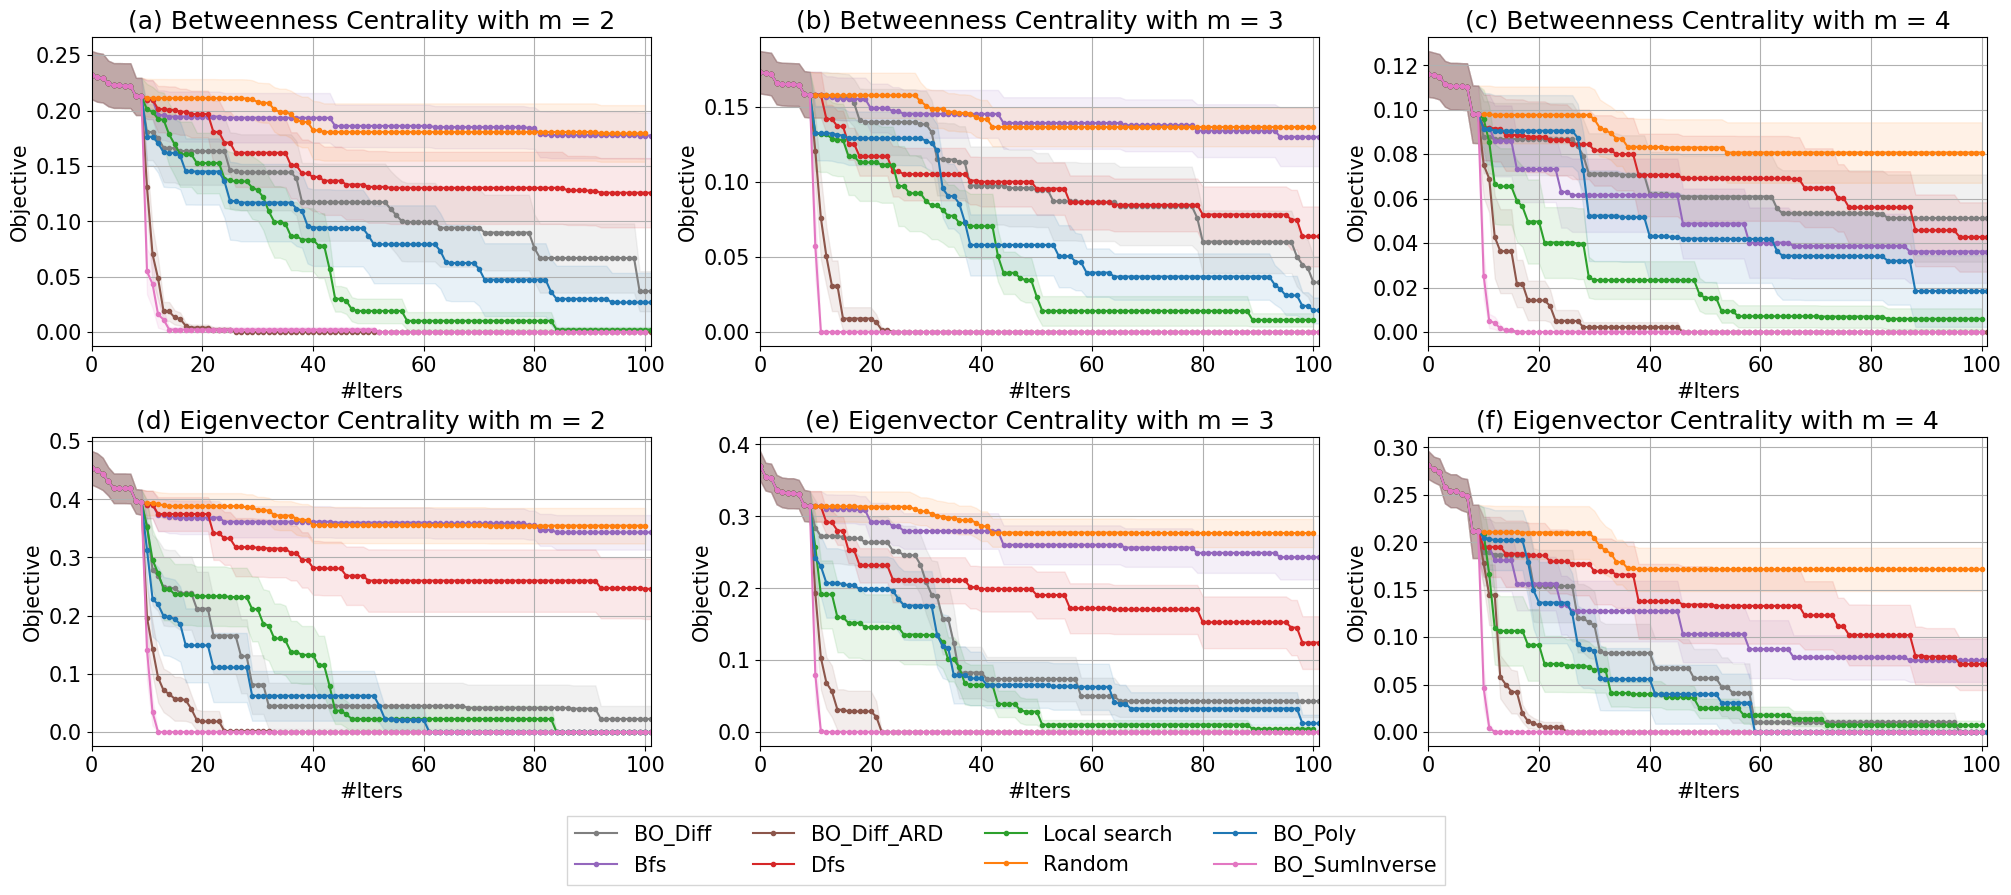

In [79]:
list_experiences = ["ba_betweenness_m-2_ninit-20_n-1000", "ba_betweenness_m-3_ninit-20_n-1000", "ba_betweenness_m-4_ninit-20_n-1000",
                    "ba_eigenvector_centrality_m-2_ninit-20_n-1000", "ba_eigenvector_centrality_m-3_ninit-20_n-1000", "ba_eigenvector_centrality_m-4_ninit-20_n-1000"]
n_rows, n_cols = 2, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    plot_result(axs[idx_row, idx_col], "./logs/centrality/", list_experiences[i], std=False)

handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('(a) Betweenness Centrality with m = 2')
axs[0, 1].title.set_text('(b) Betweenness Centrality with m = 3')
axs[0, 2].title.set_text('(c) Betweenness Centrality with m = 4')
axs[1, 0].title.set_text('(d) Eigenvector Centrality with m = 2')
axs[1, 1].title.set_text('(e) Eigenvector Centrality with m = 3')
axs[1, 2].title.set_text('(f) Eigenvector Centrality with m = 4')
#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=4)
#plt.legend()
#plt.show()


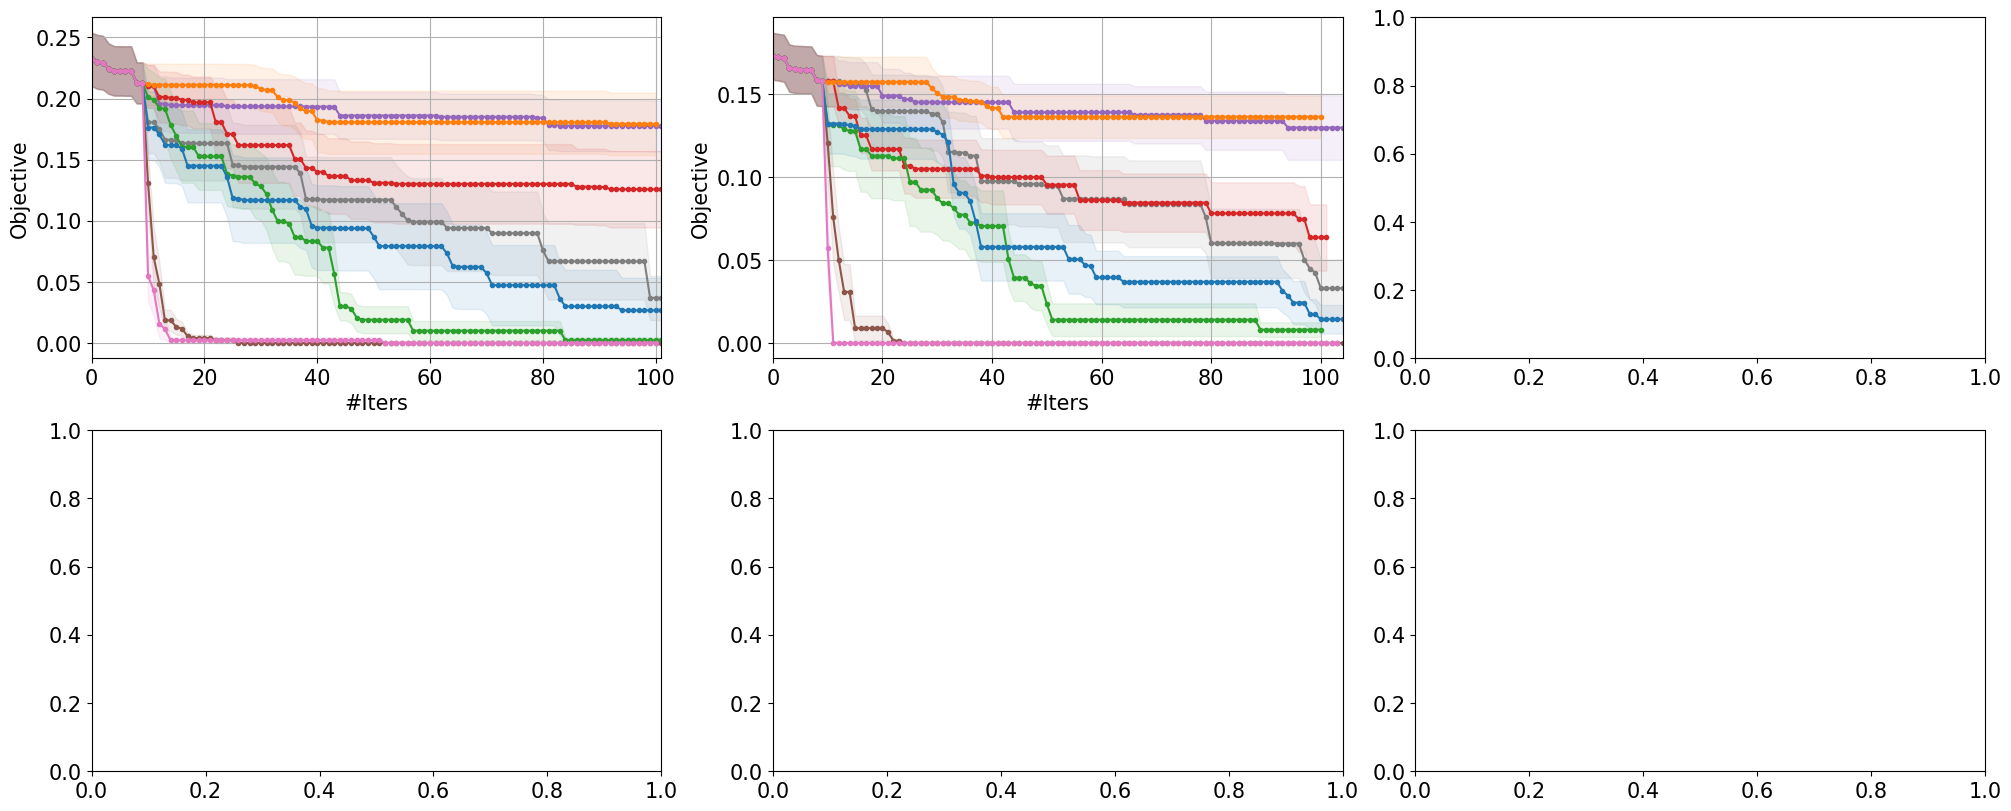

In [62]:
list_experiences = ["ba_betweenness_m-2_ninit-20_n-1000", "ba_betweenness_m-3_ninit-20_n-1000", "ba_betweenness_m-4_ninit-20_n-1000",
                    "ba_eigenvector_centrality_m-2_ninit-20_n-1000", "ba_eigenvector_centrality_m-3_ninit-20_n-1000", "ba_eigenvector_centrality_m-4_ninit-20_n-1000"]
n_rows, n_cols = 2, 3
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))


plot_result(axs[0, 0], "./logs/centrality/", list_experiences[0], std=False)

plot_result(axs[0, 1], "./logs/centrality/", list_experiences[1], std=False)

#handles, labels = subfigs[idx_row, idx_col].gca().get_legend_handles_labels()
#fig.legend(handles, labels, loc='center')
#plt.legend()
#plt.show()


In [53]:
subfigs[0,1].gca()

<Axes: xlabel='#Iters', ylabel='Objective'>

In [17]:
subfigs[0, 0].gca()

<Axes: >

In [6]:
subfigs[0,0]